# Deep Learning을 사용한 Recommendation System



## Table of Contents
### [1. Matrix Factorization to DL (w/o hidden layer)](http://localhost:8888/notebooks/Desktop/dev/RecSys/python을%20이용한%20개인화%20추천시스템/notes/Deep%20Learning%20Model%20for%20RecSys.ipynb#Matrix-Factorization-to-DL---w/o-hidden-layer)
Matrix Factorization에서 사용한 개념 - User와 Item을 공통으로 설명할 수 있는 **Latent Factor**가 있을 것이라는 아이디어 - 를 사용한다.

1. User(Item) Data를 Embedding하는 layer인 User Embedding(Item Embedding)을 만든다. 
2. User Embedding과 Item Embedding을 dot product하여 두 layer를 합친다.
3. Product Layer에 User bias / Item bias matrix를 더하여 Output을 만든다.

### [2. Matrix Factorization to DL (with hidden layers)](http://localhost:8888/notebooks/Desktop/dev/RecSys/python을%20이용한%20개인화%20추천시스템/notes/Deep%20Learning%20Model%20for%20RecSys.ipynb#Matrix-Factorization-to-DL-with-hidden-layer)

사실 1번에서 다룬 model은 hidden layer가 없다. 그리고 어차피 여러 층의 hidden layer를 거칠거라면, user embedded matrix와 item embedded matrix를 product 할 필요는 없다. User embedding, Item embedding, user bias, item bias를 flatten하여 concatenate한 후, 여러 layer를 통해 학습시키면 충분하다.


### [3. Add Variables to Model](http://localhost:8888/notebooks/Desktop/dev/RecSys/python을%20이용한%20개인화%20추천시스템/notes/Deep%20Learning%20Model%20for%20RecSys.ipynb#Add-Variables-to-Model)

직접적인 평점 데이터 이외의 다른 데이터를 사용하려면(ex. user의 특성에 관한 데이터), embedding layer와 bias matrix를 concatenate할 때, 같이 합쳐 줄 수 있다.

---
## Matrix Factorization to DL - w/o hidden layer

#### First Layer - Input
* User (One hot representation)
* Item (One hot representation)

#### Second Layer - Embedding
* User Embedding
* Item Embedding

#### Dot
* dot product User Embedding & Item Embedding

#### Add
* Producted Data
* User Bias Embedding
* Item Bias Embedding

#### Flatten

### Data Import

In [1]:
import pandas as pd
import numpy as np

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/Users/jisujung/Desktop/dev/RecSys/python을 이용한 개인화 추천시스템/data/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings= ratings[['user_id', 'movie_id', 'rating']].astype(int)

Train_Test split

In [2]:
from sklearn.utils import shuffle

TRAIN_SIZE= 0.5
ratings= shuffle(ratings)
cutoff= int(TRAIN_SIZE * len(ratings))
ratings_train= ratings.iloc[:cutoff]
ratings_test=  ratings.iloc[:cutoff]

In [4]:
K= 200
mu= ratings_train.rating.mean()
M= len(set(ratings.user_id)) + 1
N= len(set(ratings.movie_id)) + 1

In [5]:
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

### Modeling

#### Initialize Layers

In [7]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

**Embedding**

이전 Layer 층과 연결된 다음 Layer를 정의

In [8]:
user= Input(shape=(1, ))
item= Input(shape=(1, ))

P_embedding= Embedding(M, K, embeddings_regularizer= l2())(user)
Q_embedding= Embedding(N, K, embeddings_regularizer= l2())(item)
user_bias= Embedding(M, 1, embeddings_regularizer= l2())(user)
item_bias= Embedding(N, 1, embeddings_regularizer= l2())(item)

In [9]:
R= layers.dot([P_embedding, Q_embedding], axes=2)
R= layers.add([R, user_bias, item_bias])
R= Flatten()(R)

#### Define Model

In [10]:
model= Model(inputs=[user, item], outputs= R)
model.compile(
    loss=RMSE,
    optimizer= SGD(),
    metrics= [RMSE]
)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

### Training Model

In [12]:
result= model.fit(
    x= [ratings_train.user_id.values, ratings_train.movie_id.values],
    y= ratings_train.rating.values -  mu,
    epochs= 60,
    batch_size= 256,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

Epoch 1/60
196/196 [==============================] - 1s 4ms/step - loss: 5.4377 - RMSE: 1.1272 - val_loss: 5.1858 - val_RMSE: 1.1223
Epoch 2/60
196/196 [==============================] - 0s 3ms/step - loss: 5.1107 - RMSE: 1.1252 - val_loss: 4.8780 - val_RMSE: 1.1209
Epoch 3/60
196/196 [==============================] - 1s 3ms/step - loss: 4.8068 - RMSE: 1.1219 - val_loss: 4.5935 - val_RMSE: 1.1196
Epoch 4/60
196/196 [==============================] - 0s 3ms/step - loss: 4.5283 - RMSE: 1.1211 - val_loss: 4.3304 - val_RMSE: 1.1184
Epoch 5/60
196/196 [==============================] - 0s 3ms/step - loss: 4.2654 - RMSE: 1.1150 - val_loss: 4.0872 - val_RMSE: 1.1172
Epoch 6/60
196/196 [==============================] - 1s 3ms/step - loss: 4.0341 - RMSE: 1.1211 - val_loss: 3.8624 - val_RMSE: 1.1161
Epoch 7/60
196/196 [==============================] - 1s 3ms/step - loss: 3.8115 - RMSE: 1.1179 - val_loss: 3.6545 - val_RMSE: 1.1151
Epoch 8/60
196/196 [==============================] - 0s 2ms/s

### Evaluating Model

#### Plotting

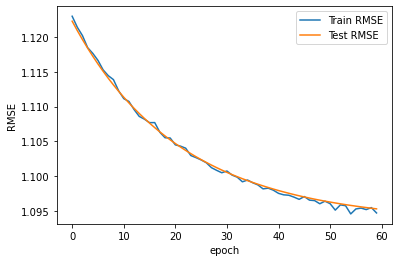

In [13]:
import matplotlib.pyplot as plt

plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label= "Test RMSE")

plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

#### Predict sample values

In [14]:
user_ids= ratings_test.user_id.values[:6]
movie_ids= ratings_test.movie_id.values[:6]

predictions= model.predict([user_ids, movie_ids]) + mu

print("Actuals: \n", ratings_test.rating[:6])
print()
print("Predictions: \n", predictions)

Actuals: 
 38078    2
5060     1
68190    4
5929     5
81301    2
97539    3
Name: rating, dtype: int64

Predictions: 
 [[3.536372 ]
 [3.4306452]
 [3.5478108]
 [3.6021094]
 [3.5395792]
 [3.5364323]]


In [15]:
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))

user_ids= ratings_test.user_id.values
movie_ids= ratings_test.movie_id.values

y_pred= model.predict([user_ids, movie_ids]) + mu
y_pred= np.ravel(y_pred, order= "C")
y_true= np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.0958504318720563

---
## Matrix Factorization to DL with hidden layer

#### First Layer - Input
* User (One hot representation)
* Item (One hot representation)

#### Second Layer - Embedding
* User Embedding
* Item Embedding

#### Concatenate
Concatenate 4 layers for mapping model
* User Embedding
* Item Embedding
* User bias
* Item bias

#### Hidden Layer

### Data Import

In [16]:
import pandas as pd
import numpy as np

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/Users/jisujung/Desktop/dev/RecSys/python을 이용한 개인화 추천시스템/data/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings= ratings[['user_id', 'movie_id', 'rating']].astype(int)

from sklearn.utils import shuffle
train_size= 0.75
ratings= shuffle(ratings)
cutoff= int(train_size * len(ratings))
ratings_train= ratings.iloc[:cutoff]
ratings_test= ratings.iloc[cutoff:]

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

K= 200
mu= ratings_train.rating.mean()
M= ratings.user_id.max() + 1
N= ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

### Modeling
#### Initialize Layers

In [17]:
user= Input(shape=(1, ))
item= Input(shape=(1, ))

P_embedding= Embedding(M, K, embeddings_regularizer= l2())(user)
Q_embedding= Embedding(N, K, embeddings_regularizer= l2())(item)

user_bias= Embedding(M, 1, embeddings_regularizer= l2())(user)
item_bias= Embedding(N, 1, embeddings_regularizer= l2())(item)

#### Concatenate Layers

In [18]:
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding= Flatten()(P_embedding)
Q_embedding= Flatten()(Q_embedding)
user_bias= Flatten()(user_bias)
item_bias= Flatten()(item_bias)

R= Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

#### Neural Network

In [19]:
R= Dense(2048)(R)
R= Activation('linear')(R)
R= Dense(256)(R)
R= Activation('linear')(R)
R= Dense(1)(R)

#### Define Model

In [20]:
model= Model(inputs= [user, item], outputs= R)
model.compile(
    loss= RMSE,
    optimizer= SGD(),
    metrics= [RMSE]
)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 200)       188800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 200)       336600      input_4[0][0]                    
____________________________________________________________________________________________

### Training

In [ ]:
result= model.fit(
    x= [ratings_train.user_id.values, ratings_train.movie_id.values],
    y= ratings_train.rating.values - mu,
    epochs= 65,
    batch_size= 512,
    validation_data=(
        [ratings_test.user_id.values, ratings_test.movie_id.values],
        ratings_test.rating.values - mu
    )
)

---
## Add Variables to Model
### Data Import

In [22]:
import pandas as pd
import numpy as np

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/Users/jisujung/Desktop/dev/RecSys/python을 이용한 개인화 추천시스템/data/u.data', sep='\t', names=r_cols, encoding='latin-1')
ratings= ratings[['user_id', 'movie_id', 'rating']].astype(int)

from sklearn.utils import shuffle
train_size= 0.75
ratings= shuffle(ratings)
cutoff= int(train_size * len(ratings))
ratings_train= ratings.iloc[:cutoff]
ratings_test= ratings.iloc[cutoff:]

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD

K= 200
mu= ratings_train.rating.mean()
M= ratings.user_id.max() + 1
N= ratings.movie_id.max() + 1

def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

#### User Data

In [23]:
u_cols= ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users= pd.read_csv('/Users/jisujung/Desktop/dev/RecSys/python을 이용한 개인화 추천시스템/data/u.user', sep='|', names= u_cols, encoding= 'latin-1')
users= users[['user_id', 'occupation']]

set(users.occupation)

{'administrator',
 'artist',
 'doctor',
 'educator',
 'engineer',
 'entertainment',
 'executive',
 'healthcare',
 'homemaker',
 'lawyer',
 'librarian',
 'marketing',
 'none',
 'other',
 'programmer',
 'retired',
 'salesman',
 'scientist',
 'student',
 'technician',
 'writer'}

#### Convert occupation (str -> int)

In [24]:
occupation= {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x]= len(occupation)
        return occupation[x]
    
users['occupation']= users['occupation'].apply(convert_occ)

#### Merge ratings data and user occupation data

In [25]:
L= len(occupation)

train_occ= pd.merge(ratings_train, users, on= 'user_id')['occupation']
test_occ= pd.merge(ratings_test, users, on= 'user_id')['occupation']

### Modeling
#### Initialzing Layers

In [26]:
user = Input(shape=(1, ))
item = Input(shape=(1, ))

P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

occ= Input(shape=(1, ))
# 3개인 이유는 없음! K를 정하는 것과 같음
occ_embedding= Embedding(L, 3, embeddings_regularizer= l2())(occ)

#### Flattening layers to concatenate

In [27]:
from tensorflow.keras.layers import Dense, Concatenate, Activation

P_embedding= Flatten()(P_embedding)
Q_embedding= Flatten()(Q_embedding)
user_bias= Flatten()(user_bias)
item_bias= Flatten()(item_bias)

occ_layer= Flatten()(occ_embedding)


R= Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])

#### Neural Network

In [28]:
R= Dense(2048)(R)
R= Activation('linear')(R)
R= Dense(256)(R)
R= Activation('linear')(R)
R= Dense(1)(R)

#### Define Model

In [29]:
model= Model(inputs=[user, item, occ], outputs= R)
model.compile(
    loss= RMSE,
    optimizer= SGD(),
    metrics= [RMSE]
)

In [30]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 1, 200)       188800      input_5[0][0]                    
____________________________________________________________________________________________

### Training

In [ ]:
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],
    ratings_test.rating.values - mu
  )
)